# Statistical analysis between coastal and adjacent ocean cells around Australia

## Importing packages

In [1]:
from datetime import date 
from datetime import datetime
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.ndimage as ndimage
from scipy.ndimage import convolve
from scipy.ndimage.measurements import label, find_objects
import xarray as xr

## Opening the mask file

In [2]:
# static_era5.nc is a land sea mask 

ds = xr.open_dataset('/g/data/e14/cp3790/Charuni/Heatwaves/static_era5.nc').sel(longitude=slice(113.0, 154.0), latitude=slice(-10.0, -44.0))
mask = xr.where(ds.lsm==0, 0, 1)

## Finding coastal cells
Using scipy.ndimage convolve

k is an array of weights, with the same number of dimensions as input

In [3]:
k =([[[1, 1, 1],
    [1, 0, 1],
    [1, 1, 1]]])

input array 'mask' is convolved with 'k', mode='constant' which ensures that the input is extended by filling all values beyond the edge with the same constant value

In [4]:
c = convolve(mask, k, mode='constant')

coastal array is 1 when the mask==1 and the sum of neighbouring cells is < 8 (which means at least one cell is neighbouring a 0 (or sea grid cell)

In [5]:
coastal = np.logical_and(mask == 1, c < 8)

In [19]:
def fix(ds):
    # This function makes the original data array repeatable so that it matches with the shape of the other data array.

    trial = ds
    i = 0
    while i < 13514:  # <-- Here, 13514 corresponds to the timesteps in land dataset 
        trial = xr.concat([trial, ds], 'time')
        i+=1
    trial = trial.isel(time = slice(0,13514))
    # to specify the dates/time 
    trial.coords['time'] = np.arange(date(1982,1,1).toordinal(),date(2018,12,31).toordinal()+1) 
    
    t = np.arange(date(1982,1,1).toordinal(),date(2018,12,31).toordinal()+1)
    dates = [date.fromordinal(tt.astype(int)) for tt in t]
    
    trial.coords['time'] = dates

    return trial

In [20]:
new_coastal = fix(coastal)  # new_coastal will now have the same shape as anom 

In [21]:
coast_grids = new_coastal.where(new_coastal != 0)

In [23]:
coast_sel_stacked = coast_grids.stack(latlon=('latitude', 'longitude')).dropna(dim='latlon')
# this stacks all lat, lon pairs corresponding to the coastal cells 

## Severity datasets

In [25]:
# thw severity 
thw = xr.open_dataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-T2M/thw-events-new.nc').sel(time=slice('1982', '2018'), longitude=slice(113.0, 154.0), latitude=slice(-10.0, -44.0))
anom = thw['severity']

In [26]:
# mhw severity 
files = sorted(glob.glob('/g/data/e14/cp3790/Charuni/MHW-updated/mhw_severity.pc90.*.nc'))
mhw = xr.open_mfdataset(files, combine='by_coords').sel(time=slice('1982', '2018'), lon=slice(113.0, 154.0), lat=slice(-44.0, -10.0))

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/coding/times.py:83: SerializationWarning: Ambiguous reference date string: 01-01-01 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-01 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


Using the stacked latlon locations of coastal cells to find the location of the neighbouring cells in the ssta dataset, which I now call 'localcells'

In [29]:
sev = mhw.severity

In [30]:
# the mhw dataset has a resolution of 0.25 degrees; plus/minus 0.3 ensures that the selections overlaps, accounting for
# any shift between the two grids 

for (lat, lon) in coast_sel_stacked.latlon.values:
    centre = sev.sel(lat=lat, lon=lon, method='nearest')
    centre_lat = centre.lat.values
    centre_lon = centre.lon.values
    localcells = sev.sel(lat=slice(centre_lat-0.3,centre_lat+0.3), lon=slice(centre_lon-0.3,centre_lon+0.3))
   

Using the stacked latlon locations of coastal cells to find the location of the corresponding cells in the (land) anom dataset, which I now call 'landcells'

In [31]:
for (lat, lon) in coast_sel_stacked.latlon.values:
    centre = anom.sel(latitude=lat, longitude=lon, method='nearest')
    centre_lat = centre.latitude.values
    centre_lon = centre.longitude.values
    landcells = anom.sel(latitude=centre_lat, longitude=centre_lon)
    

In [32]:
# Creating data arrays for all land cells and corresponding local cells. 

series1 = []
series2 = []
for (lat, lon) in coast_sel_stacked.latlon.values:
    cen = anom.sel(latitude=lat, longitude=lon, method='nearest')
    cen_lat = cen.latitude.values
    cen_lon = cen.longitude.values
    landcells = anom.sel(latitude=cen_lat, longitude=cen_lon)
    centre = sev.sel(lat=lat, lon=lon, method='nearest')
    centre_lat = centre.lat.values
    centre_lon = centre.lon.values
    localcells = sev.sel(lat=slice(centre_lat-0.3,centre_lat+0.3), lon=slice(centre_lon-0.3,centre_lon+0.3))
    series1.append(landcells)
    series2.append(localcells.mean(dim=('lat', 'lon')))

In [ ]:
sata_ds = xr.concat(series1, 'ncell')

In [19]:
ssta_ds = xr.concat(series2, 'ncell').assign_coords(longitude=sata_ds.longitude, latitude=sata_ds.latitude)

# the ocean dataset is now assigned the same lat lon values as the coastal points 

In [ ]:
# creating a new data array 'new_coastal' which is like 'anom' and we fill it with values from sata_ds

new_coastal = xr.full_like(anom, fill_value=np.nan)
for d in sata_ds:
    new_coastal.loc[dict(latitude=d.latitude, longitude=d.longitude)] = d.values

In [ ]:
# I have said anom for the reference object as I want the ssta values also to be saved in the land coordinates

new_ocean = xr.full_like(anom, fill_value=np.nan)
for d in ssta_ds:
    new_ocean.loc[dict(latitude=d.latitude, longitude=d.longitude)] = d.values

In [23]:
new_coastal.to_netcdf('aus-coastal-sev.nc')

In [22]:
new_ocean.to_netcdf('aus-ocean-sev-2.nc')

In [3]:
aus_coastal = xr.open_dataarray('/g/data/e14/cp3790/Charuni/Tasmania/aus-coastal-sev.nc')

In [4]:
aus_ocean = xr.open_dataarray('/g/data/e14/cp3790/Charuni/Tasmania/aus-ocean-sev-2.nc')

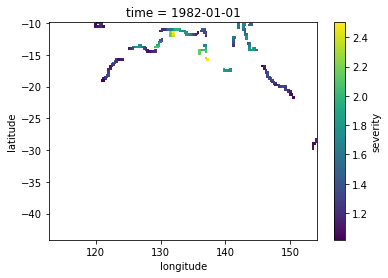

In [26]:
aus_ocean.isel(time=0).plot()

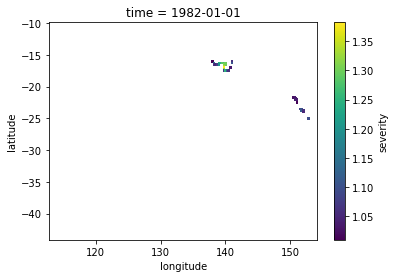

In [7]:
aus_coastal.isel(time=0).plot()